In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
#IMPORTATION DES DONNEES
df_origin= pd.read_csv('consommation-electrique-par-secteurs-dactivite.csv', delimiter=';')
df_origin2= pd.read_csv('production-electrique-par-filiere.csv', delimiter=';')


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#INDEXATION PAR LE CODE IRIS
tags = ['Code IRIS','Nb sites secteur résidentiel',
       'Conso totale secteur résidentiel (MWh)',
       'Conso moyenne secteur résidentiel (MWh)', 'Nb sites Agriculture',
       'Conso totale Agriculture (MWh)', 'Nb sites Industrie',
       'Conso totale Industrie (MWh)', 'Nb sites Tertiaire',
       'Conso totale Tertiaire (MWh)']
df_origin_group=df_origin.groupby('Code IRIS')
df_origin_group1=df_origin_group.get_group('100150000')


In [4]:
#LIMITATION A LA DERNIERE ANNEE
idx_last_yr = df_origin.groupby(['Code IRIS'], sort=False)['Année'].transform(max) == df_origin['Année']
df_origin_last_yr=df_origin[idx_last_yr]
df_origin_last_yr_trunc=df_origin_last_yr[tags]

df_origin_last_yr_trunc=df_origin_last_yr_trunc.set_index('Code IRIS')


In [5]:
#NORMALISATION A [0,1]
df=df_origin_last_yr_trunc
df -= df.min()
df /= df.max()

In [6]:
#REMPLISSAGE DES CASES VIDES PAR DES 0
df_woNan=df.fillna(0)

In [7]:
#from pandas.plotting import scatter_matrix
#scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')
#df_origin_last_yr_trunc_minmax = df_origin_last_yr_trunc.transform(df_origin_last_yr_trunc)

#REDUCTION DE DIMENSION POUR VISUALISATION
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True) 

In [8]:
#LIMITATION DU NOMBRE DE SAMPLES
nb_samples=1000
import random
random_idx=random.sample(range(len(df_woNan.index)), nb_samples)
ndarray_tsne=model.fit_transform(df_woNan.ix[random_idx]) 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


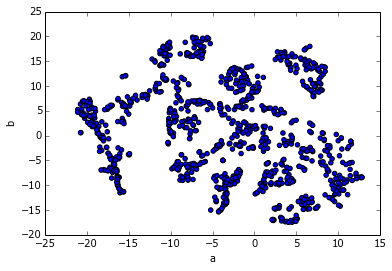

In [9]:
#PLOT EN 2D PRE-CLUSTER
df_tsne=pd.DataFrame(ndarray_tsne,columns=['a', 'b'])
df_tsne.plot.scatter(x='a', y='b');

In [10]:
#CLUSTERISATION HIERARCHIQUE
from sklearn.cluster import AgglomerativeClustering
hierarch_cluster=AgglomerativeClustering(n_clusters=8)
cluster_nmb= np.zeros(shape=(nb_samples,1))
cluster_nmb=hierarch_cluster.fit_predict(df_tsne, y=cluster_nmb)

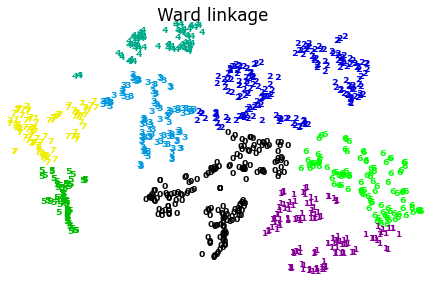

In [11]:
#PLOT EN 2D POST-CLUSTER
from matplotlib import pyplot as plt
def plot_clustering(X_red, y,labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_clustering(df_tsne.as_matrix(), hierarch_cluster.labels_, hierarch_cluster.labels_, "Ward linkage")

In [12]:
#PLOT EN 2D POST-CLUSTER ALTERNATIF (SANS NUMERO DE CLUSTER)
#from matplotlib import pyplot
#pyplot.scatter(df_tsne.as_matrix()[:,0], df_tsne.as_matrix()[:,1], c=hierarch_cluster.labels_)
#pyplot.show()

In [13]:
#AJOUT DU NUMERO DU CLUSTER
df_woNan_selec=df_woNan.ix[random_idx]
df_woNan_selec['cluster']=hierarch_cluster.labels_


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#STATISTIQUES PAR CLUSTER
df_woNan_selec_group=df_woNan_selec.groupby('cluster')
df_woNan_selec_stats=df_woNan_selec_group.mean()
